In [5]:
! kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 96% 114M/119M [00:00<00:00, 163MB/s] 
100% 119M/119M [00:00<00:00, 146MB/s]


In [ ]:
! unzip /content/chest-ctscan-images.zip

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt
#import cv2 as cv
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical
import os

In [8]:
train_path_str = '/content/Data/train'
val_path_str = '/content/Data/valid'
test_path_str = '/content/Data/test'

In [9]:
test_classes = os.listdir(test_path_str)
print(test_classes)

['normal', 'squamous.cell.carcinoma', 'adenocarcinoma', 'large.cell.carcinoma']


In [10]:
input_shape = (224,224,3)
num_classes = 4

trainGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32'
)
valGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

testGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

In [11]:
train_data = trainGenertor.flow_from_directory(
    train_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

val_data = valGenertor.flow_from_directory(
    val_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_data = testGenertor.flow_from_directory(
    test_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = False
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [12]:
VGG16_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)
for layer in VGG16_model.layers :
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
from keras import activations
model = Sequential()
model.add(VGG16_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(num_classes,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [14]:
model.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [15]:
results = model.fit(train_data,validation_data=val_data,epochs=100,verbose = 1)


Epoch 1/100
39/39 [==============================] - 31s 430ms/step - loss: 1.6898 - accuracy: 0.4290 - val_loss: 1.2736 - val_accuracy: 0.5000
Epoch 2/100
39/39 [==============================] - 15s 382ms/step - loss: 1.2088 - accuracy: 0.4747 - val_loss: 1.1404 - val_accuracy: 0.4861
Epoch 3/100
39/39 [==============================] - 15s 381ms/step - loss: 1.1107 - accuracy: 0.4861 - val_loss: 1.3187 - val_accuracy: 0.3333
Epoch 4/100
39/39 [==============================] - 14s 350ms/step - loss: 1.0254 - accuracy: 0.5204 - val_loss: 0.9130 - val_accuracy: 0.4861
Epoch 5/100
39/39 [==============================] - 15s 389ms/step - loss: 0.9741 - accuracy: 0.5579 - val_loss: 1.0269 - val_accuracy: 0.5278
Epoch 6/100
39/39 [==============================] - 15s 396ms/step - loss: 0.8896 - accuracy: 0.6166 - val_loss: 1.0198 - val_accuracy: 0.5694
Epoch 7/100
39/39 [==============================] - 14s 361ms/step - loss: 0.8535 - accuracy: 0.6232 - val_loss: 0.9155 - val_accuracy:

In [16]:
loss, acc = model.evaluate(test_data,verbose = 1)

20/20 [==============================] - 4s 222ms/step - loss: 0.2830 - accuracy: 0.9016


In [17]:
import seaborn as sns
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
report = classification_report(true_label,predictions)
print(report)

20/20 [==============================] - 3s 152ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       120
           1       0.88      0.90      0.89        51
           2       1.00      0.94      0.97        54
           3       0.86      0.91      0.89        90

    accuracy                           0.90       315
   macro avg       0.91      0.91      0.91       315
weighted avg       0.90      0.90      0.90       315



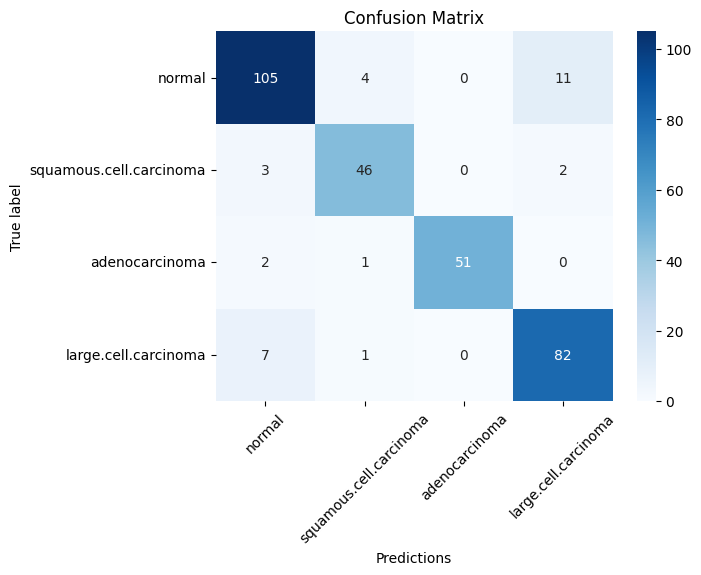

In [18]:
conf_mat = confusion_matrix(true_label,predictions)
sns.heatmap(conf_mat ,fmt='g',annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation = 45)
plt.show()

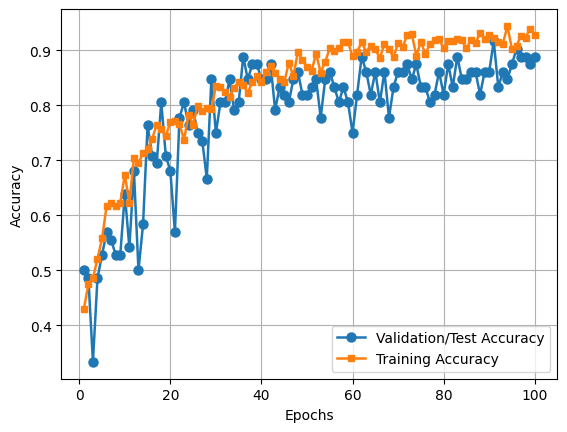

In [19]:
res = results.history
train_acc = res['accuracy']
val_accuracy = res['val_accuracy']
epochs = range(1, len(train_acc) + 1)

line1 = plt.plot(epochs, val_accuracy, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, train_acc, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

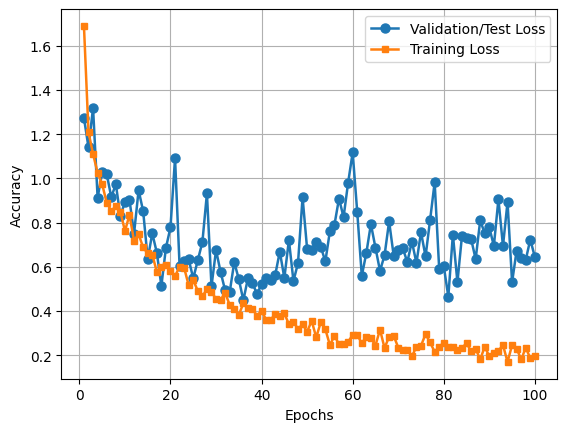

In [20]:
res = results.history
train_loss = res['loss']
val_loss = res['val_loss']
epochs = range(1, len(train_loss) + 1)

line1 = plt.plot(epochs, val_loss, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, train_loss, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
